<a href="https://colab.research.google.com/github/sivanikom/Automated-Labor-Detection/blob/main/IH_05_Code_Executed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/Research/PRETERM/term-preterm-ehg-database-1.0.1.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content/sample_data/preterm')

In [ ]:
# check what is inside each directory and content
!pwd
!ls -all '/content/sample_data/preterm'

/content
total 12
drwxr-xr-x 3 root root 4096 Jul  8 23:57 .
drwxr-xr-x 1 root root 4096 Jul  8 23:57 ..
drwxr-xr-x 3 root root 4096 Jul  8 23:57 term-preterm-ehg-database-1.0.1


In [ ]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 8.0 MB/s 


In [ ]:
import wfdb
import numpy as np
import csv
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
FEATURES = ['Gestation',
'Age',
'Parity',
'Abortions',
'Weight',
'Hypertension',
'Diabetes',
'Placental_position',
'Bleeding_first_trimester',
'Bleeding_second_trimester',
'Funneling',
'Smoker']
print(len(FEATURES))

12


# Data Preprocessing
1. delete the records with missing features
2. encode the values

In [ ]:
import pandas as pd
from sklearn import preprocessing

In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/Research/PRETERM/all_records_and_signals.csv')
raw_df.head()

,Gestation,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker,Root Mean Square,Median Frequency,Peak Frequency,Sample Entropy
0,35.0,30,0,0,58,no,no,front,no,no,negative,no,27.9148,0.3109,0.3159,0.502
1,38.6,None,None,None,63,None,None,end,yes,no,negative,None,54.2390,0.1426,0.1126,0.243
2,38.6,None,None,None,70,None,None,end,yes,no,negative,None,26.1735,0.1598,0.1049,0.396
3,37.1,27,0,1,100,no,no,front,no,no,negative,no,7.5545,0.1750,0.1522,0.732
4,38.6,28,0,2,72,no,no,front,no,no,negative,no,12.7331,0.1816,0.1816,0.817


Drop the incomplete records
and store it in a new csv file

In [ ]:
dropped_incomplete_df = raw_df.drop(raw_df[raw_df.eq('None').any(1)].index, inplace=False)
dropped_incomplete_df.to_csv('incomplete_record_dropped.csv')

In [ ]:
# rename the untilted column
incomplete_record_dropped_df = pd.read_csv('incomplete_record_dropped.csv')
incomplete_record_dropped_df = incomplete_record_dropped_df.rename(columns={'Unnamed: 0':'record_number'})
incomplete_record_dropped_df.to_csv('incomplete_record_dropped.csv', index=False)
pre_encoding_df = pd.read_csv('incomplete_record_dropped.csv')
pre_encoding_df.head()

,record_number,Gestation,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker,Root Mean Square,Median Frequency,Peak Frequency,Sample Entropy
0,0,35.0,30,0,0,58,no,no,front,no,no,negative,no,27.9148,0.3109,0.3159,0.502
1,3,37.1,27,0,1,100,no,no,front,no,no,negative,no,7.5545,0.1750,0.1522,0.732
2,4,38.6,28,0,2,72,no,no,front,no,no,negative,no,12.7331,0.1816,0.1816,0.817
3,5,38.9,30,0,0,64,no,no,end,yes,no,negative,no,8.4929,0.3059,0.3402,0.747
4,6,40.3,37,1,1,79,no,no,end,no,no,negative,no,14.9220,0.1294,0.1144,0.499


### checking the data

In [ ]:
# 300 -> 169 records, 131 incomplete records dropped
len(raw_df),len(pre_encoding_df)

(300, 169)

In [ ]:
# 38 -> 19 preterm records
len(raw_df[raw_df['Gestation'] < 37]), len(pre_encoding_df[pre_encoding_df['Gestation'] < 37]),

(38, 19)

## Encoding Strategy: Ordinal Variables
assigning each feature to a number in a series (1,2,3...) with sklearn.preprocessing

replace text with numbers:

- no: 0
- yes: 1
- front:1
- end: 0
- negative: 0
- positive: 1

check the unique values for each category

In [ ]:
CATEGORICAL_FEATURES = [
'Hypertension',
'Diabetes',
'Placental_position',
'Bleeding_first_trimester',
'Bleeding_second_trimester',
'Funneling',
'Smoker'
]
unique_categorical_values = []
for feature in CATEGORICAL_FEATURES:
    unique_categorical_values.append(pre_encoding_df['{}'.format(feature)].unique())
unique_categorical_values

[array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['front', 'end'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['negative', 'positive'], dtype=object),
 array(['no', 'yes'], dtype=object)]

map the unique categorical values to its corresponsing ordinal value

In [ ]:
ordinal_encoding_df = pre_encoding_df.copy()
encoding_dict = {}
for value in unique_categorical_values:
    le = preprocessing.LabelEncoder()
    le.fit(value)
    vals = list(le.transform(value))
    for i,j in zip(list(le.classes_), vals):
        encoding_dict[i] = vals[j]
encoding_dict

{'end': 0, 'front': 1, 'negative': 0, 'no': 0, 'positive': 1, 'yes': 1}

In [ ]:
for key in encoding_dict.keys():
    ordinal_encoding_df.replace(key, encoding_dict[key], inplace=True)
ordinal_encoding_df.head()

,record_number,Gestation,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker,Root Mean Square,Median Frequency,Peak Frequency,Sample Entropy
0,0,35.0,30,0,0,58,0,0,1,0,0,0,0,27.9148,0.3109,0.3159,0.502
1,3,37.1,27,0,1,100,0,0,1,0,0,0,0,7.5545,0.1750,0.1522,0.732
2,4,38.6,28,0,2,72,0,0,1,0,0,0,0,12.7331,0.1816,0.1816,0.817
3,5,38.9,30,0,0,64,0,0,0,1,0,0,0,8.4929,0.3059,0.3402,0.747
4,6,40.3,37,1,1,79,0,0,0,0,0,0,0,14.9220,0.1294,0.1144,0.499


check the data types before writing to csv file

In [ ]:
ordinal_encoding_df.dtypes

record_number                  int64
Gestation                    float64
Age                            int64
Parity                         int64
Abortions                      int64
Weight                         int64
Hypertension                   int64
Diabetes                       int64
Placental_position             int64
Bleeding_first_trimester       int64
Bleeding_second_trimester      int64
Funneling                      int64
Smoker                         int64
Root Mean Square             float64
Median Frequency             float64
Peak Frequency               float64
Sample Entropy               float64
dtype: object

## Output csv file
imbalanced dataset:
with 19 perterm records and 150 term records

In [ ]:
ordinal_encoding_df.to_csv('ordinal_encoding.csv', index=False)
test = pd.read_csv('ordinal_encoding.csv')
test.head()

,record_number,Gestation,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker,Root Mean Square,Median Frequency,Peak Frequency,Sample Entropy
0,0,35.0,30,0,0,58,0,0,1,0,0,0,0,27.9148,0.3109,0.3159,0.502
1,3,37.1,27,0,1,100,0,0,1,0,0,0,0,7.5545,0.1750,0.1522,0.732
2,4,38.6,28,0,2,72,0,0,1,0,0,0,0,12.7331,0.1816,0.1816,0.817
3,5,38.9,30,0,0,64,0,0,0,1,0,0,0,8.4929,0.3059,0.3402,0.747
4,6,40.3,37,1,1,79,0,0,0,0,0,0,0,14.9220,0.1294,0.1144,0.499


DATA EXPLORATION

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('ordinal_encoding.csv')
preterm_df = df[df['Gestation'] < 37]
term_df = df[df['Gestation'] >= 37]

In [ ]:
preterm_df.describe()

,record_number,Gestation,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker,Root Mean Square,Median Frequency,Peak Frequency,Sample Entropy
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,143.789474,35.042105,28.631579,0.421053,0.421053,67.842105,0.0,0.0,0.631579,0.105263,0.105263,0.157895,0.052632,14.786300,0.190489,0.141147,0.577632
std,72.981412,1.879810,4.449851,0.507257,0.768533,8.858537,0.0,0.0,0.495595,0.315302,0.315302,0.374634,0.229416,6.932793,0.050068,0.065094,0.214999
min,0.000000,31.000000,20.000000,0.000000,0.000000,57.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.013000,0.143800,0.081900,0.043000
25%,105.000000,34.500000,26.000000,0.000000,0.000000,59.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.119100,0.161450,0.103900,0.461000
50%,120.000000,35.700000,28.000000,0.000000,0.000000,66.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,14.312800,0.168800,0.117300,0.502000
75%,204.500000,36.400000,31.500000,1.000000,1.000000,73.500000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,17.324000,0.203600,0.158000,0.779500
max,282.000000,36.700000,39.000000,1.000000,3.000000,84.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,29.463000,0.317900,0.315900,0.866000


In [ ]:
term_df.describe()

,record_number,Gestation,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker,Root Mean Square,Median Frequency,Peak Frequency,Sample Entropy
count,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,137.826667,39.53600,29.220000,0.493333,0.346667,69.593333,0.013333,0.020000,0.526667,0.153333,0.026667,0.040000,0.080000,14.015771,0.233055,0.161109,0.679040
std,86.273153,1.08345,4.769689,0.711805,0.685288,9.399484,0.115082,0.140469,0.500961,0.361516,0.161647,0.196616,0.272202,8.458765,0.263282,0.243379,0.157897
min,3.000000,37.00000,20.000000,0.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.531100,0.114900,0.084900,0.229000
25%,65.500000,38.90000,26.000000,0.000000,0.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.320250,0.155750,0.102100,0.575000
50%,136.500000,39.70000,29.000000,0.000000,0.000000,68.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.621100,0.171450,0.112950,0.704000
75%,210.250000,40.30000,32.000000,1.000000,0.750000,75.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,17.745850,0.201925,0.152100,0.791500
max,299.000000,44.00000,43.000000,3.000000,3.000000,103.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,66.800200,2.118100,2.761800,0.981000


transforming gestation period to label __run once__

In [ ]:
boolean_mask = pd.Series(df['Gestation'] < 37)
df.loc[boolean_mask,'Gestation'] = 'preterm'
inverted_boolean_mask = boolean_mask != True
df.loc[inverted_boolean_mask,'Gestation'] = 'term'
df['Gestation'].head()

0    preterm
1       term
2       term
3       term
4       term
Name: Gestation, dtype: object

## ~~Principal Component Analysis
A __linear feature extraction technique__:

performs a linear mapping of the data to a lower-dimensionnal space, while maximizing the variance in the low-dimensional representation

aka: drop the least important features. New features are independent of one another.

Feature Extraction = __create new independent features__ that is a combination of each of the old independent features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
FEATURES = [
'Age',
'Parity',
'Abortions',
'Weight',
'Hypertension',
'Diabetes',
'Placental_position',
'Bleeding_first_trimester',
'Bleeding_second_trimester',
'Funneling',
'Smoker',
'Root Mean Square',
'Median Frequency',
'Peak Frequency',
'Sample Entropy'
]

In [ ]:
x = df.loc[:, FEATURES].values
print(len(x[0]))
y = df['Gestation']

15


In [ ]:
x = StandardScaler().fit_transform(x)
x[0]

array([ 0.17958137, -0.70428441, -0.51377848, -1.22493757, -0.10943513,
       -0.13443321,  0.9258201 , -0.41666667, -0.19185884, -0.23717082,
       -0.28867513,  1.67178688,  0.33302879,  0.68396403, -0.99111259])

### trying 2 dimensions
it only covers 25% of the information, did not capture enough info

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['pc 1', 'pc 2'])
principal_df.head()

,pc 1,pc 2
0,-1.538913,1.897976
1,1.197301,-1.332375
2,0.764800,-0.835963
3,0.598894,0.594839
4,-0.037954,-0.217114


combine features with target, to a new data frame

In [ ]:
final_df = pd.concat([principal_df, df[['Gestation']]],axis=1)
final_df.head()

,pc 1,pc 2,Gestation
0,-1.538913,1.897976,preterm
1,1.197301,-1.332375,term
2,0.764800,-0.835963,term
3,0.598894,0.594839,term
4,-0.037954,-0.217114,term


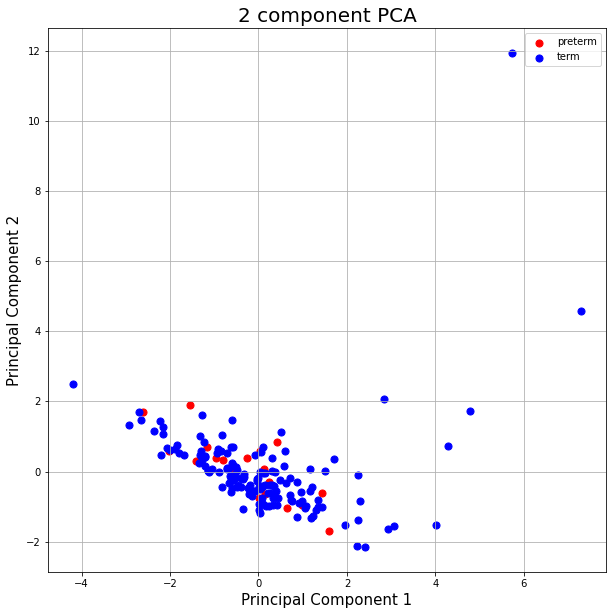

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['preterm', 'term']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['Gestation'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'pc 1'], final_df.loc[indicesToKeep, 'pc 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
sum(pca.explained_variance_ratio_)

0.25849840250228473

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [ ]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['pc 1', 'pc 2', 'pc 3'])
principal_df.head()
final_df = pd.concat([principal_df, df[['Gestation']]],axis=1)
final_df.head()

,pc 1,pc 2,pc 3,Gestation
0,-1.538913,1.897976,0.317906,preterm
1,1.197301,-1.332375,-0.768286,term
2,0.764800,-0.835963,-0.570211,term
3,0.598894,0.594839,-0.681488,term
4,-0.037954,-0.217114,1.313243,term


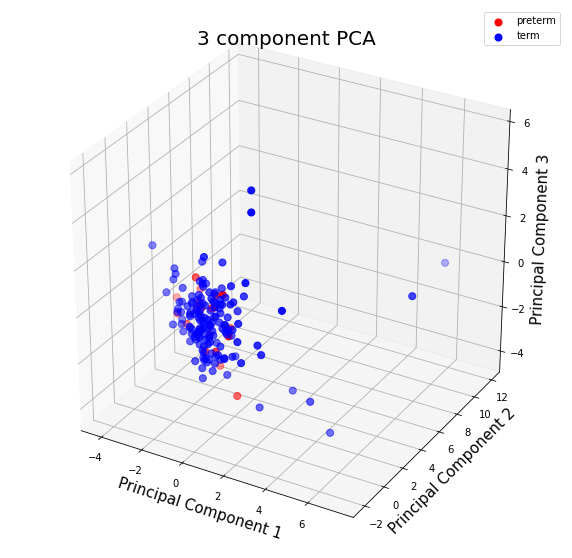

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title('3 component PCA', fontsize = 20)
targets = ['preterm', 'term']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['Gestation'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'pc 1'], final_df.loc[indicesToKeep, 'pc 2'], final_df.loc[indicesToKeep, 'pc 3'], c = color, s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
px_fig = px.scatter_3d(final_df, x='pc 1', y='pc 2', z='pc 3', color='Gestation')
px_fig.show()

# testing different ML models
Binary Classification Problem
1. Decision Tree
    - Regressor vs. Classifier
2. Random Forest

3. Logistic Regression
4. Baysian Network
5. SVM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
input_df = pd.read_csv('ordinal_encoding.csv')
gestation_period = input_df['Gestation']
input_stuff = input_df.drop(['Gestation', 'record_number'], axis=1)
input_stuff.head()

,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker,Root Mean Square,Median Frequency,Peak Frequency,Sample Entropy
0,30,0,0,58,0,0,1,0,0,0,0,27.9148,0.3109,0.3159,0.502
1,27,0,1,100,0,0,1,0,0,0,0,7.5545,0.1750,0.1522,0.732
2,28,0,2,72,0,0,1,0,0,0,0,12.7331,0.1816,0.1816,0.817
3,30,0,0,64,0,0,0,1,0,0,0,8.4929,0.3059,0.3402,0.747
4,37,1,1,79,0,0,0,0,0,0,0,14.9220,0.1294,0.1144,0.499


In [ ]:
gestation_period.head()

0    35.0
1    37.1
2    38.6
3    38.9
4    40.3
Name: Gestation, dtype: float64

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [ ]:
input_train, input_test, output_train, output_test = train_test_split(input_stuff, gestation_period, test_size=.2, random_state=81)

In [ ]:
len(output_train[output_train < 37]), len(output_test[output_test < 37])

(14, 5)

In [ ]:
regressor = DecisionTreeRegressor(random_state=69)
regressor.fit(input_train, output_train)

DecisionTreeRegressor(random_state=69)

In [ ]:
output_predicted = regressor.predict(input_test)

#### With normalization
- using the StandardScaler, assuming that the data is normally distributed (?)

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaled_input_df = StandardScaler().fit_transform(input_df)
scaled_input_train, scaled_input_test, scaled_output_train, scaled_output_test = train_test_split(standard_scaled_input_df, gestation_period, test_size=.2, random_state=81)

In [ ]:
regressor = DecisionTreeRegressor(random_state=69)
regressor.fit(scaled_input_train, scaled_output_train)
scaled_output_predicted = regressor.predict(scaled_input_test)

#### Optimizations
1. max number of leaf nodes

### Validation
1. Accuracy
1. MSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [ ]:
# without normalization
mean_squared_error(output_test, output_predicted)

5.408823529411758

In [ ]:
# with normalization
mean_squared_error(scaled_output_test, scaled_output_predicted)

0.017352941176470786

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaled_input_df = StandardScaler().fit_transform(input_df)
scaled_input_train1, scaled_input_test, scaled_output_train1, y_test = train_test_split(standard_scaled_input_df, gestation_period, test_size=.1, random_state=81)
scaled_input_train, scaled_input_valid, y_train, y_validate = train_test_split(scaled_input_train1, scaled_output_train1, test_size=.1, random_state=81)

In [ ]:
X_train = np.expand_dims(scaled_input_train, -1)
X_test = np.expand_dims(scaled_input_test, -1)
X_validate = np.expand_dims(scaled_input_valid, -1)

print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)
print(X_test.shape)
print(y_test.shape)

(136, 17, 1)
(136,)
(16, 17, 1)
(16,)
(17, 17, 1)
(17,)


In [ ]:
from keras.models import Sequential
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
# weights = {0:1, 1:5}

model.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=["accuracy"])
r = model.fit(X_train, y_train,
              validation_data=(X_validate, y_validate),
              batch_size=50,
              epochs=epochs,
#               class_weight=weights
             )

Epoch 1/10
3632/3632 [==============================] - 39s 11ms/step - loss: 0.0541 - accuracy: 0.9916 - val_loss: 0.0205 - val_accuracy: 0.9990
Epoch 2/10
3632/3632 [==============================] - 39s 11ms/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 0.0133 - val_accuracy: 0.9991
Epoch 3/10
3632/3632 [==============================] - 38s 10ms/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 0.0114 - val_accuracy: 0.9992
Epoch 4/10
3632/3632 [==============================] - 38s 10ms/step - loss: 0.0066 - accuracy: 0.9989 - val_loss: 0.0092 - val_accuracy: 0.9993
Epoch 5/10
3632/3632 [==============================] - 39s 11ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0086 - val_accuracy: 0.9993
Epoch 6/10
3632/3632 [==============================] - 40s 11ms/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0081 - val_accuracy: 0.9993
Epoch 7/10
3632/3632 [==============================] - 37s 10ms/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 0.0073 -

In [ ]:

score = model.evaluate(X_test, y_test)


1774/1774 [==============================] - 6s 4ms/step - loss: 0.0065 - accuracy: 0.9993


In [ ]:
print(score)

[0.0064660548232495785, 0.9992951154708862]


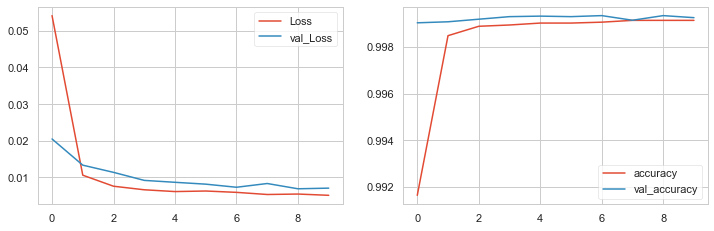

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()